## Importing Required libraries

In [36]:
import warnings, math
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib

from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, balanced_accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from xgboost import XGBClassifier
plt.rcParams["figure.figsize"] = (7, 5)

## Loading the CTG Dataset

In [21]:
df = pd.read_csv("CTG.csv")

In [22]:
# Check for the number of columns and rows in the dataset
print(df.shape)
# Display the first few rows of the dataframe to understand its structure   
df.head(3)

(2130, 40)


,FileName,Date,SegFile,b,e,LBE,LB,AC,FM,UC,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Variab10.txt,12/1/1996,CTG0001.txt,240.0,357.0,120.0,120.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,2.0
2,Fmcs_1.txt,5/3/1996,CTG0002.txt,5.0,632.0,132.0,132.0,4.0,0.0,4.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0


## Understanding our Target: 

Our main goal is to support clinicians in spotting fetal distress which is represented by the NSP column under 3 categories (1 = Normal, 2 = Suspect, and 3 = Pathologic) in the data frame. The data will be useless if the NSP value is not given, so we can start the data cleaning by removing all the rows that without NSP data. 

In [23]:
# Drop rows where NSP is NaN
df = df[df['NSP'].notna()]  
# Check the shape again after dropping NaN target rows
print(df.shape) 

(2126, 40)


## Check for any other missing values

In [24]:
# Check for missing values
missing_data = df.isnull().sum()

# Track if any column has missing data
any_missing = False

# Iterate through each column and check if there are missing values
for column, missing_count in missing_data.items():
    if missing_count > 0:
        print(f"Column '{column}' has {missing_count} missing values.")
        any_missing = True

# If no columns have missing data
if not any_missing:
    print("None of the columns have missing data.")


None of the columns have missing data.


## Checking for Duplicate Rows

In [25]:
# Define and assign the variable for duplicate rows in the dataframe
duplicates = df[df.duplicated()]

# Print the number of duplicate rows and the duplicate rows themselves
Number_of_duplicates = duplicates.shape[0] 

if Number_of_duplicates > 0:
    print("Duplicated rows:")
    for index, row in duplicates.iterrows():
        print(row)
else:
    print("No duplicates found.")


No duplicates found.


In [26]:
print(f"Cleaned data shape: {df.shape}")

Cleaned data shape: (2126, 40)


## Breaking down the problem statement: 

How can we build a solution that carefully interprets the patterns hidden in a baby’s heart rate and the mother’s contractions, in order to automatically identify signs of fetal distress that might otherwise go unnoticed during labor? 

We need to analyze primary data that is collected form the CTG to understand their correlation to fetal distress. 


## Clinical Considerations: 

If the CTG data is shorter than 10 minutes:

Key signals like decelerations or abnormal variability might be missed, leading to false negatives, i.e failing to identify distress.

Shorter data windows may also increase the likelihood of false positives, where non-distress data is flagged as problematic.

In conclusion, 10 minutes is the minimum recommended time for CTG monitoring to ensure accurate detection of fetal distress and reliable predictions for clinical decision-making. Therefore, we decided to only include data that is collected for at least 10 minutes, so that the model has more reliable data to train on.

Number of records with duration less than 10 minutes: 486 

Original Dataset:
 NSP
1.0    1655
2.0     295
3.0     176
Name: count, dtype: int64

DataSet removed (less than 10 mins):
 NSP
1.0    359
2.0     81
3.0     46
Name: count, dtype: int64


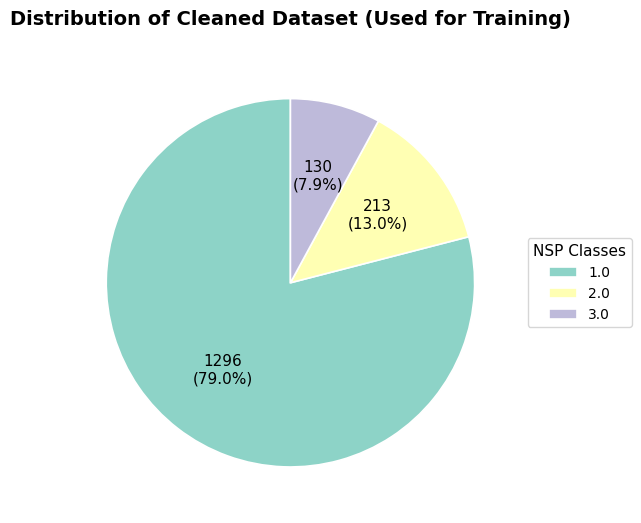

In [27]:
# Identify rows where the duration (e - b) is less than 600 seconds (10 minutes)
short_duration_rows = df[(df['e'] - df['b']) < 600]  

counts1 = df["NSP"].value_counts()  # Initial dataset
counts2 = short_duration_rows["NSP"].value_counts() # Dataset with duration < 10 mins
counts3 = df["NSP"].value_counts() - short_duration_rows["NSP"].value_counts()   # Cleaned dataset 

print(f"Number of records with duration less than 10 minutes: {len(short_duration_rows)} \n")
print("Original Dataset:\n", counts1 )
print("\nDataSet removed (less than 10 mins):\n", counts2)

def func(pct, allvalues):
    absolute = int(pct / 100. * sum(allvalues))
    return f"{absolute}\n({pct:.1f}%)"

plt.figure(figsize=(6, 6))

# Custom color palette for clearer visuals
colors = plt.cm.Set3(range(len(counts3)))

# Create pie chart
wedges, texts, autotexts = plt.pie(
    counts3,
    autopct=lambda pct: func(pct, counts3),
    startangle=90,
    colors=colors,
    textprops={"fontsize": 11, "color": "black"},
    wedgeprops={"edgecolor": "white", "linewidth": 1.2}
)

# Add legend and title
plt.legend(
    counts3.index,
    title="NSP Classes",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    fontsize=10,
    title_fontsize=11
)

plt.title("Distribution of Cleaned Dataset (Used for Training)", fontsize=14, fontweight="bold", pad=20)
plt.tight_layout()
plt.show()

In [28]:
df['duration'] = df['e'] - df['b']
df = df[df['duration'] > 600]

# Check the shape of the filtered dataframe (number of rows and columns)
print(f"Shape of the dataframe after filtering: {df.shape}")


Shape of the dataframe after filtering: (1638, 41)


## Let's take a closer look at the data in the various columns
### Non-essential Columns: 
Based on medical considerations and model training efficiency, drop the following: 
- Non-Numeric Data (FileName, SegFile, Date)
- Time Instants in seconds (b, e) 
- LBE --> Used as reference only, not useful for analysis 
- DR  --> Repetitive decelerations, not useful for analysis

In [29]:
drop_cols = ["FileName", "SegFile", "Date", "b", "e", "LBE", "DR", ]
drop_cols = [c for c in drop_cols if c in df.columns]
if drop_cols:
    df = df.drop(columns=drop_cols)
df.columns

Index(['LB', 'AC', 'FM', 'UC', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'DL', 'DS',
       'DP', 'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean', 'Median',
       'Variance', 'Tendency', 'A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS',
       'SUSP', 'CLASS', 'NSP', 'duration'],
      dtype='object')

## Visulizing data on a Histogram

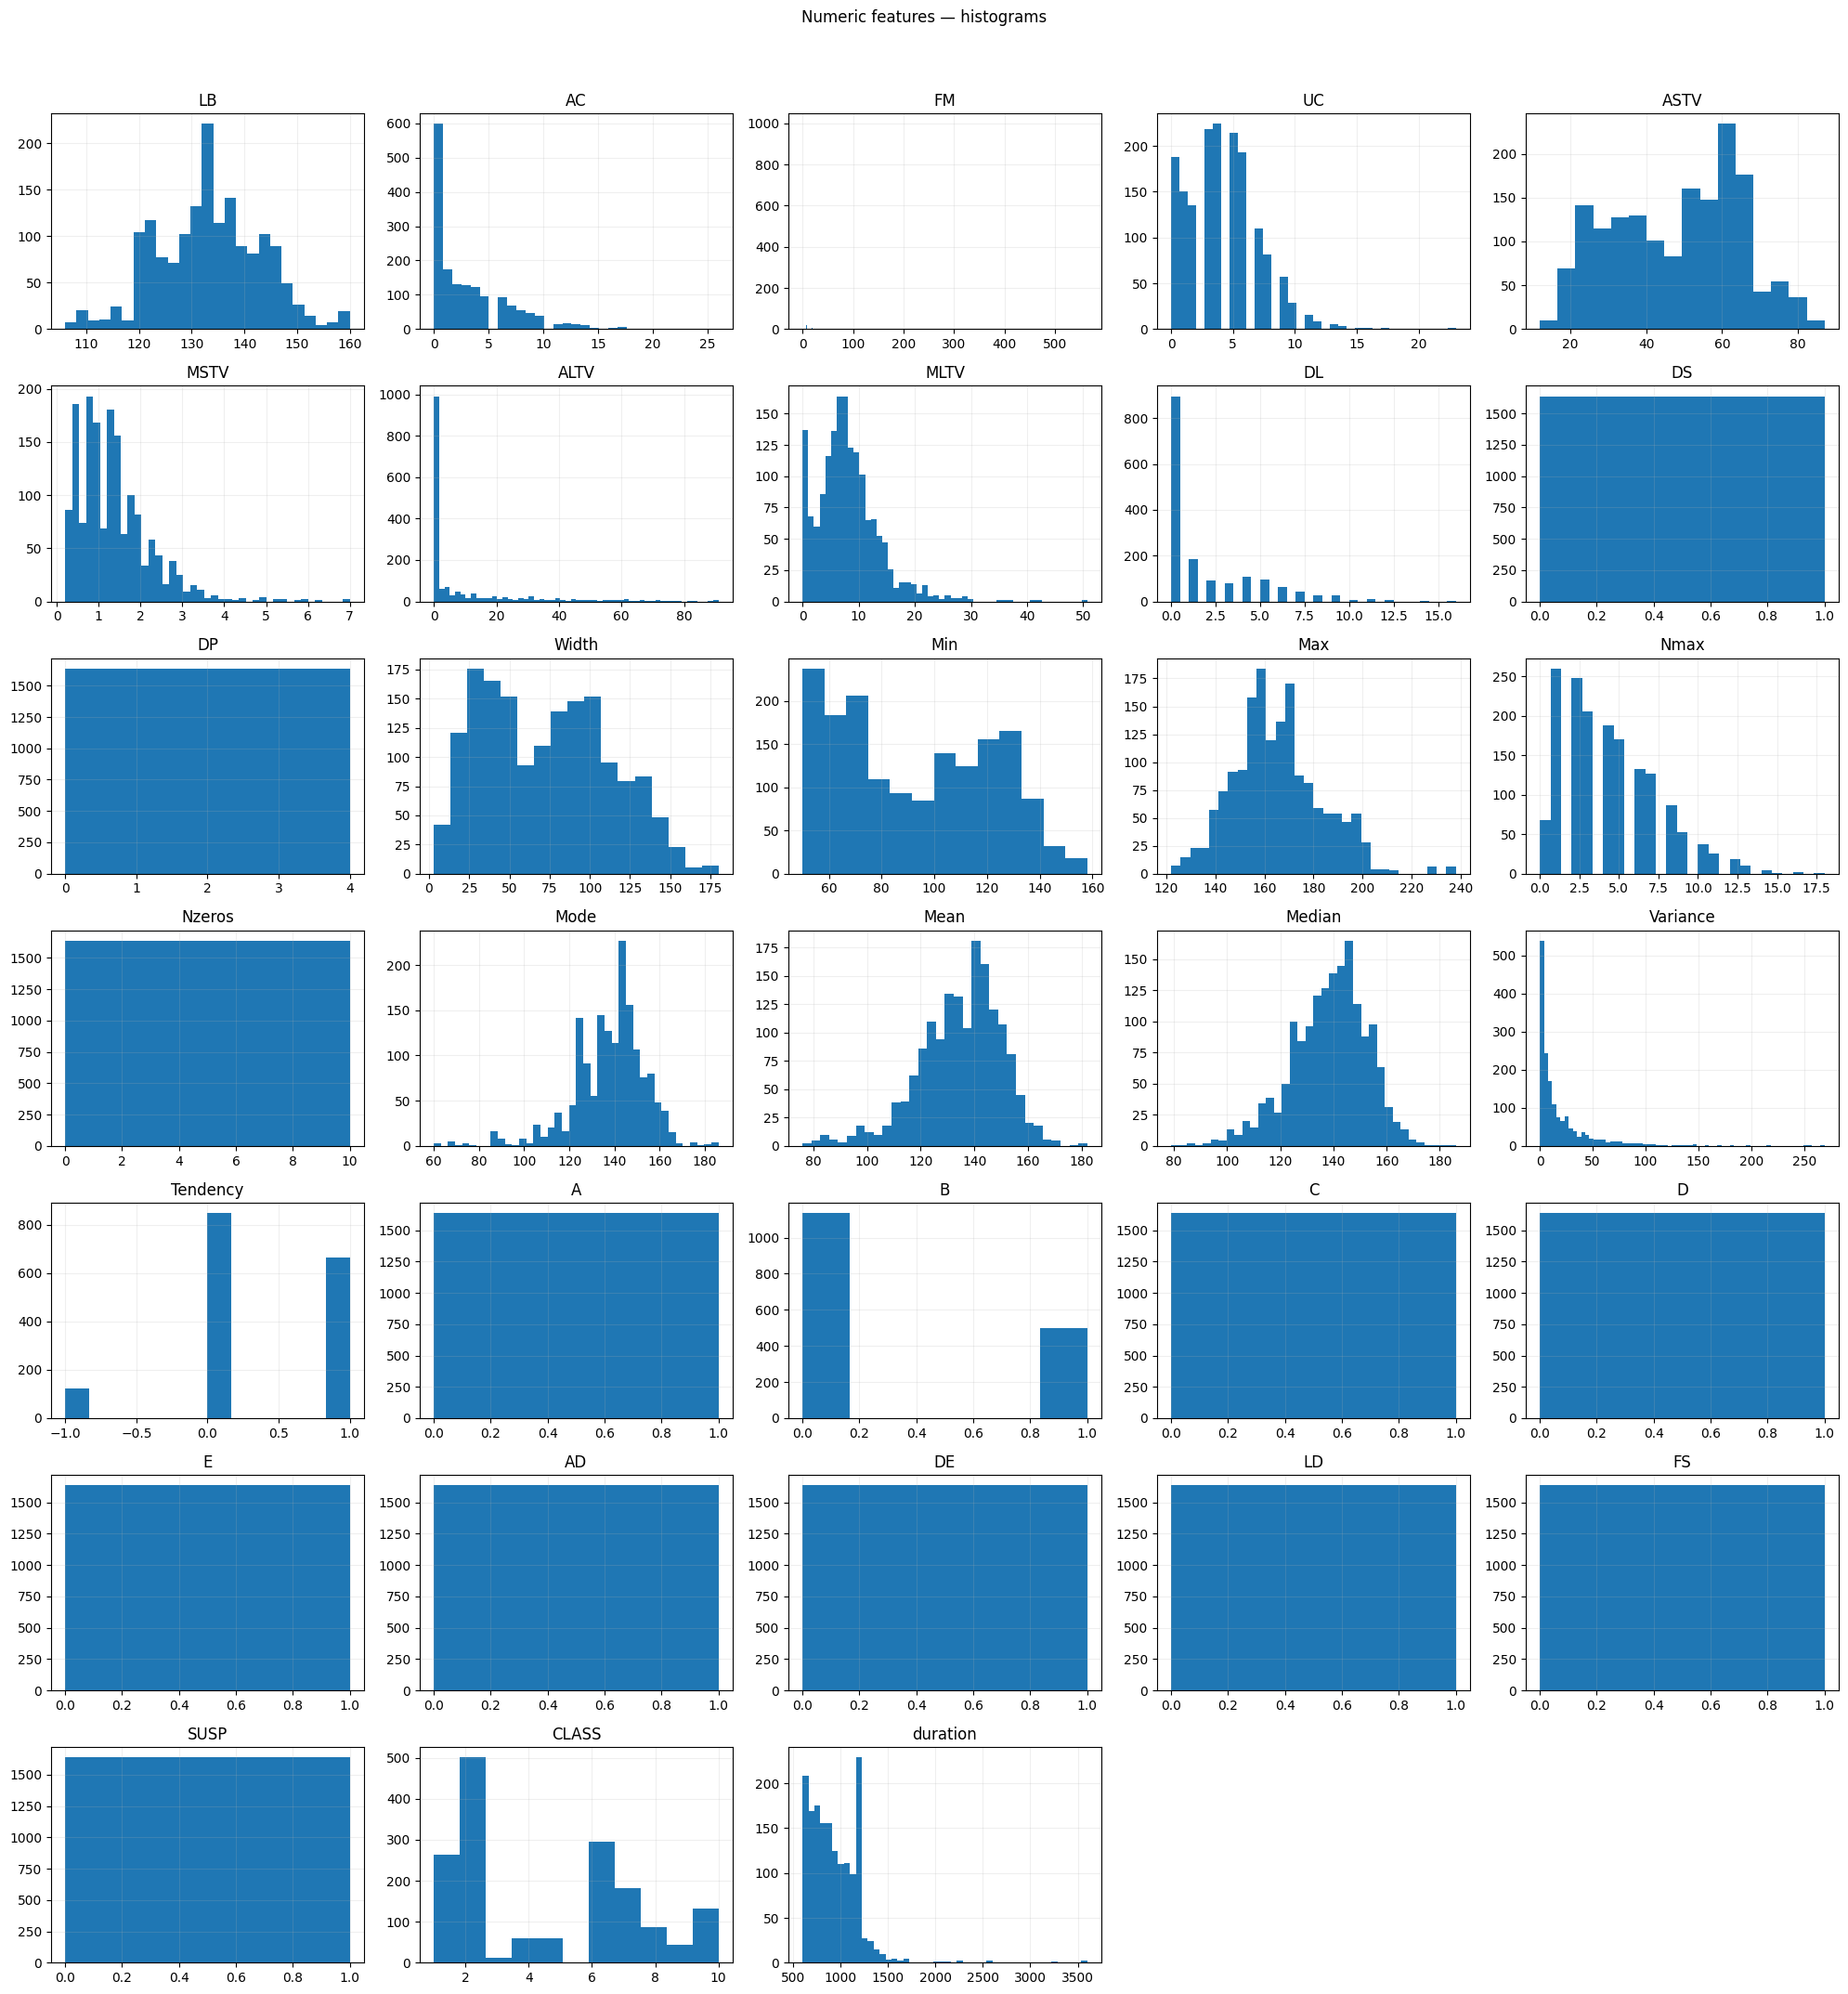

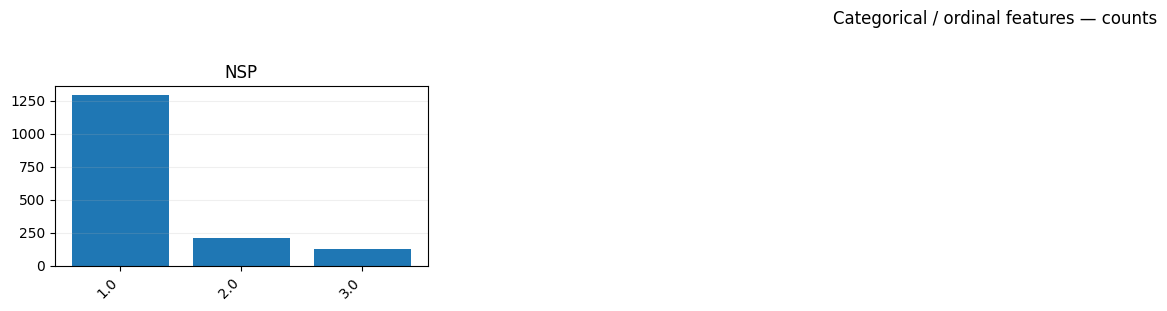

In [30]:
def plot_all_histograms(df: pd.DataFrame, ncols: int = 4, bins: str | int = "fd",
                        exclude: list[str] = None, rotate_xticks: bool = True):

    exclude = exclude or []
    cols = [c for c in df.columns if c not in exclude]

    # Separate by datatype and treat NSP specially
    num_cols = [c for c in cols if pd.api.types.is_numeric_dtype(df[c])]
    cat_cols = [c for c in cols if c not in num_cols]
    if "NSP" in num_cols:  
        num_cols.remove("NSP")
        cat_cols.append("NSP")

    # Histograms for numeric features
    if num_cols:
        n = len(num_cols)
        nrows = math.ceil(n / ncols)
        fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows))
        axes = np.array(axes).reshape(-1)
        for i, col in enumerate(num_cols):
            ax = axes[i]
            data = df[col].dropna()
            ax.hist(data, bins=bins)
            ax.set_title(col)
            ax.grid(alpha=0.2)
        for j in range(i+1, len(axes)): 
            axes[j].set_visible(False)
        fig.suptitle("Numeric features — histograms", y=1.02, fontsize=12)
        fig.tight_layout()
        plt.show()

    # Categorical feature counts
    if cat_cols:
        n = len(cat_cols)
        nrows = math.ceil(n / ncols)
        fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows))
        axes = np.array(axes).reshape(-1)
        for i, col in enumerate(cat_cols):
            ax = axes[i]
            counts = df[col].astype("category").value_counts(dropna=False).sort_index()
            ax.bar([str(x) for x in counts.index], counts.values)
            ax.set_title(col)
            if rotate_xticks:
                for tick in ax.get_xticklabels():
                    tick.set_rotation(45)
                    tick.set_ha("right")
            ax.grid(axis="y", alpha=0.2)
        for j in range(i+1, len(axes)):
            axes[j].set_visible(False)
        fig.suptitle("Categorical / ordinal features — counts", y=1.02, fontsize=12)
        fig.tight_layout()
        plt.show()     
        
plot_all_histograms(df, ncols=5, bins="fd")

## After Histogram Analysis: 

We noticed that more of the columns can be removed because they do not add any value to the training data.  

In [31]:
exclude_cols = ["Min","Max", "NMax", "Nzeros", "CLASS", "SUSP", "FS", "Nmax", "A", "B", "C", "D", "E", "AD", "DE", "LD", "duration"]  # drop any that don’t exist
exclude_cols = [c for c in exclude_cols if c in df.columns]
if exclude_cols:
    df1 = df.drop(columns=exclude_cols)
df1.columns

Index(['LB', 'AC', 'FM', 'UC', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'DL', 'DS',
       'DP', 'Width', 'Mode', 'Mean', 'Median', 'Variance', 'Tendency', 'NSP'],
      dtype='object')

## Understanding the correlation between different features

### Spearman correlation

Spearman works with ranks and is fine for ordinal data.

It checks whether higher NSP values (e.g., going from Normal → Suspicious → Pathological) are associated with increases/decreases in your numerical features.

## Correlation between ASTV/ALTV and Width/Variance


In [32]:
spearman_corr = df1.corr(method="spearman")["NSP"].drop("NSP")
print(spearman_corr)


LB          0.194811
AC         -0.482260
FM          0.053254
UC         -0.214189
ASTV        0.450859
MSTV       -0.244545
ALTV        0.364997
MLTV       -0.169244
DL         -0.031122
DS          0.121449
DP          0.358879
Width      -0.116466
Mode       -0.019963
Mean       -0.004053
Median     -0.022303
Variance   -0.135543
Tendency   -0.064330
Name: NSP, dtype: float64


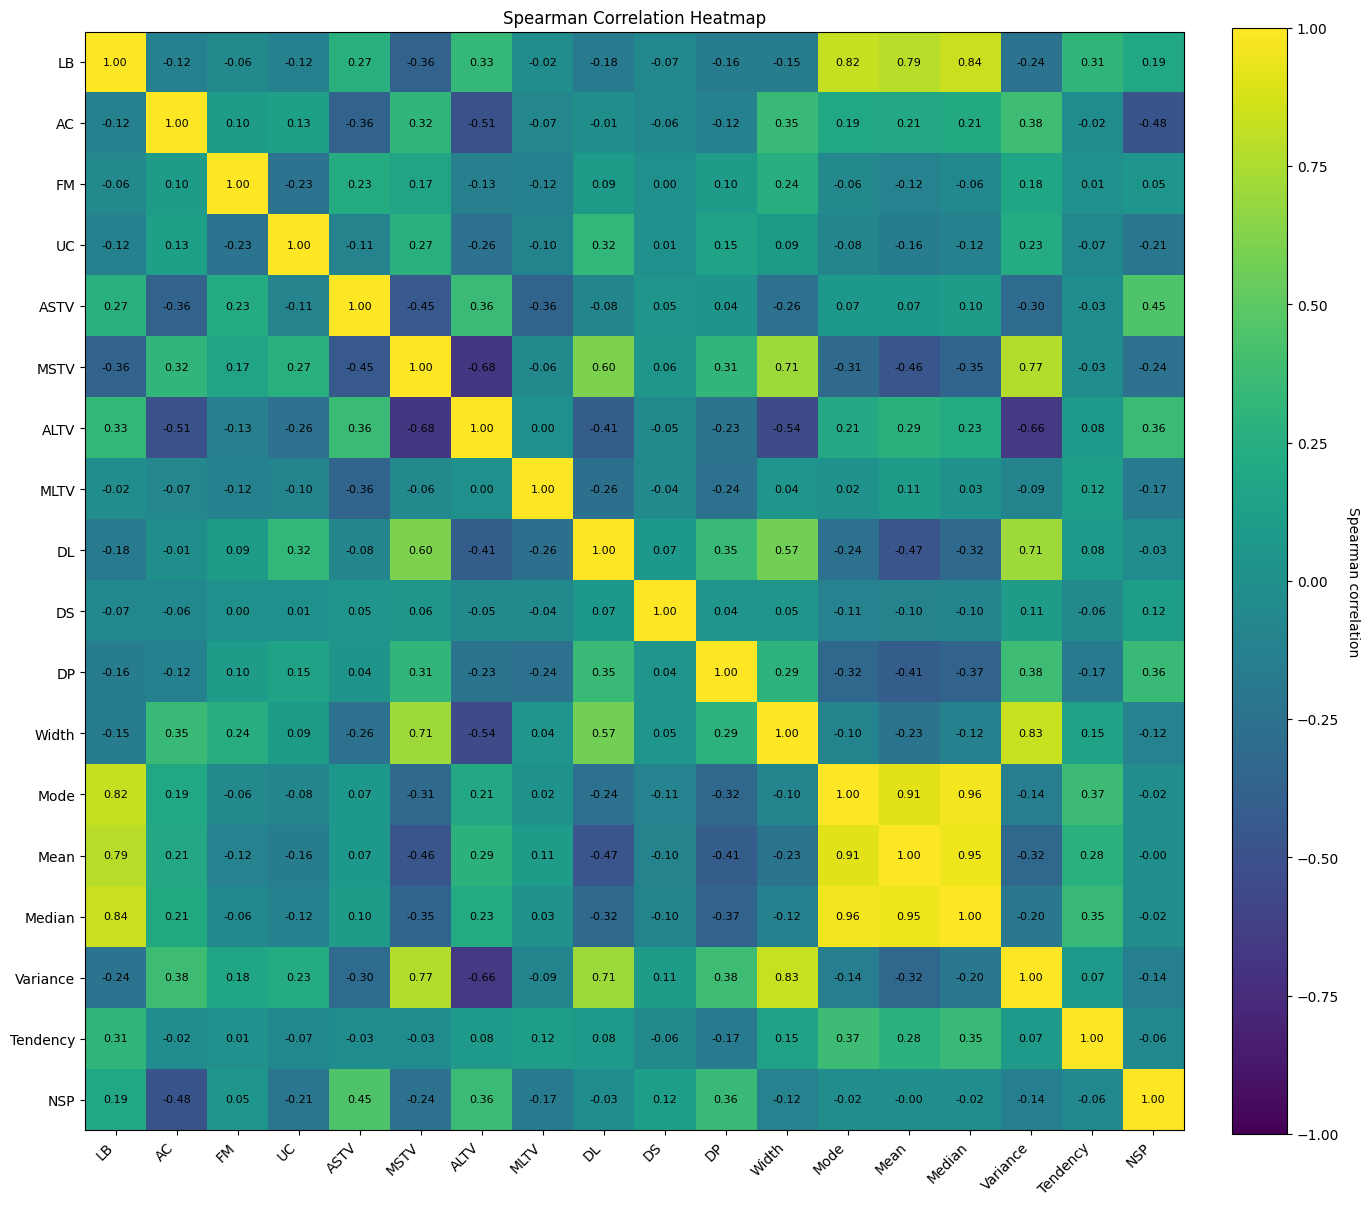

In [33]:
# Keep only numeric columns 
df_num = df1.select_dtypes(include="number")

# Spearman correlation 
corr = df_num.corr(method="spearman")

# Plot heatmap
fig, ax = plt.subplots(figsize=(0.6*len(corr.columns)+3, 0.6*len(corr.columns)+3))
im = ax.imshow(corr.values, vmin=-1, vmax=1)

# Axis ticks & labels
ax.set_xticks(np.arange(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=45, ha="right")
ax.set_yticks(np.arange(len(corr.index)))
ax.set_yticklabels(corr.index)

# Colorbar
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Spearman correlation", rotation=270, labelpad=15)

# Display correlation value for each cell
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        ax.text(j, i, f"{corr.iloc[i, j]:.2f}", ha="center", va="center", fontsize=8)

ax.set_title("Spearman Correlation Heatmap")
plt.tight_layout()
plt.show()


In [34]:
df2 = df[["ASTV", "MSTV", "ALTV", "MLTV", "Width", "Variance"]].copy()

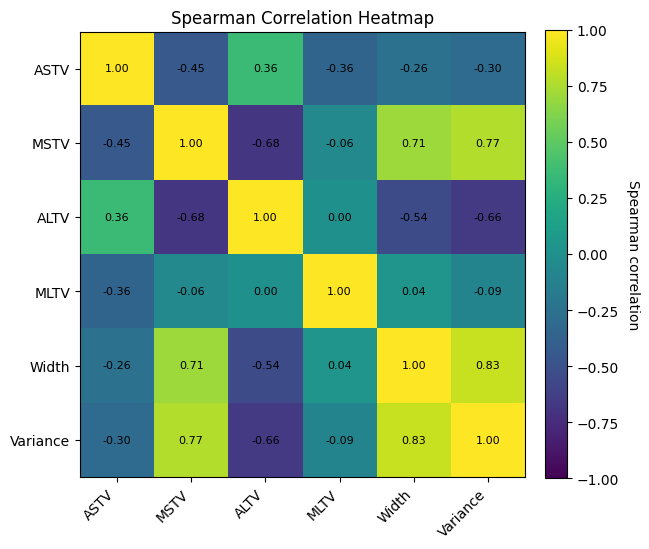

In [35]:
# Keep only numeric columns 
df_num = df2.select_dtypes(include="number")

# Spearman correlation (good for ordinal NSP)
corr = df_num.corr(method="spearman")

#Plot heatmap
fig, ax = plt.subplots(figsize=(0.6*len(corr.columns)+3, 0.6*len(corr.columns)+3))

im = ax.imshow(corr.values, vmin=-1, vmax=1)

# Axis ticks & labels
ax.set_xticks(np.arange(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=45, ha="right")
ax.set_yticks(np.arange(len(corr.index)))
ax.set_yticklabels(corr.index)

# Colorbar
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Spearman correlation", rotation=270, labelpad=15)

# Optional: annotate each cell with the correlation value
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        ax.text(j, i, f"{corr.iloc[i, j]:.2f}", ha="center", va="center", fontsize=8)

ax.set_title("Spearman Correlation Heatmap")
plt.tight_layout()
plt.show()


##                     End of Data Cleaning
